# 0. Imports and Load Data

In [1]:
import os
import glob
import random
import json
from pathlib import Path
import pandas as pd
import yaml
import cv2
import matplotlib.pyplot as plt
from collections import Counter
from ultralytics import YOLO
import warnings
import numpy as np
import pprint


warnings.filterwarnings('ignore')

In [2]:
DATA_YAML_PATH = "../data/data.yaml"

assert os.path.exists(DATA_YAML_PATH), f"data.yaml not found in {DATA_YAML_PATH}"

with open(DATA_YAML_PATH, "r") as f:
    data_cfg = yaml.safe_load(f)

data_cfg

{'train': '../data/train/images',
 'val': '../data/valid/images',
 'test': '../data/test/images',
 'nc': 17,
 'names': ['car',
  'cardboard box',
  'forklift',
  'freight container',
  'gloves',
  'helmet',
  'ladder',
  'license plate',
  'person',
  'qr code',
  'road sign',
  'safety vest',
  'traffic cone',
  'traffic light',
  'truck',
  'van',
  'wood pallet'],
 'roboflow': {'workspace': 'srafil-ar',
  'project': 'forklift-6ms6v',
  'version': 1,
  'license': 'CC BY 4.0',
  'url': 'https://universe.roboflow.com/srafil-ar/forklift-6ms6v/dataset/1'}}

In [3]:
train_dir = data_cfg.get("train")
val_dir   = data_cfg.get("val")
test_dir  = data_cfg.get("test", None)
class_names = data_cfg.get("names", [])
nc = int(data_cfg.get("nc", len(class_names)))

print("Train images dir:", train_dir)
print("Val images dir  :", val_dir)
print("Test images dir :", test_dir)
print("Classes (nc)     :", nc)
print("Classes name:", class_names)

Train images dir: ../data/train/images
Val images dir  : ../data/valid/images
Test images dir : ../data/test/images
Classes (nc)     : 17
Classes name: ['car', 'cardboard box', 'forklift', 'freight container', 'gloves', 'helmet', 'ladder', 'license plate', 'person', 'qr code', 'road sign', 'safety vest', 'traffic cone', 'traffic light', 'truck', 'van', 'wood pallet']


# 1. Data Analysis: First Sight

In [4]:
def yolo_label_paths(img_dir: str) -> list:
    img_paths = []
    for ext in ("*.jpg", "*.jpeg", "*.png", "*.bmp"):
        img_paths.extend(glob.glob(os.path.join(img_dir, ext)))
    label_paths = []
    for ip in img_paths:
        lp = ip.replace(os.sep + "images" + os.sep, os.sep + "labels" + os.sep)
        lp = os.path.splitext(lp)[0] + ".txt"
        label_paths.append((ip, lp))
    return label_paths

def read_yolo_labels(label_path: str):
    if not os.path.exists(label_path):
        return []
    rows = []
    with open(label_path, "r") as f:
        for line in f:
            parts = line.strip().split()
            if len(parts) >= 5:
                cls_id = int(float(parts[0]))
                cx, cy, w, h = map(float, parts[1:5])
                rows.append((cls_id, cx, cy, w, h))
    return rows


In [5]:
def analyze_split(img_dir: str, class_names: list):
    pairs = yolo_label_paths(img_dir)
    per_class = Counter()
    objs_per_image = []
    areas = []

    for _, lbl_path in pairs:
        labels = read_yolo_labels(lbl_path)
        objs_per_image.append(len(labels))
        for (cls_id, cx, cy, w, h) in labels:
            per_class[cls_id] += 1
            areas.append(w * h)

    df_classes = pd.DataFrame({
        "class_id": list(per_class.keys()),
        "count": list(per_class.values())
    })
    df_classes["class_name"] = df_classes["class_id"].apply(lambda i: class_names[i] if i < len(class_names) else str(i))

    df_objs = pd.DataFrame({"objects_per_image": objs_per_image})
    df_areas = pd.DataFrame({"bbox_area_norm": areas})

    return df_classes.sort_values("count", ascending=False), df_objs, df_areas

df_classes_train, df_objs_train, df_areas_train = analyze_split(train_dir, class_names)
df_classes_train.head(), df_objs_train.describe(), df_areas_train.describe()

(   class_id  count         class_name
 1         2  24213           forklift
 0         8  20480             person
 3         1   1266      cardboard box
 4        12   1023       traffic cone
 6         3    447  freight container,
        objects_per_image
 count       20546.000000
 mean            2.405237
 std             2.472610
 min             1.000000
 25%             1.000000
 50%             2.000000
 75%             3.000000
 max            47.000000,
        bbox_area_norm
 count    49418.000000
 mean         0.155603
 std          0.224430
 min          0.000010
 25%          0.010547
 50%          0.045352
 75%          0.203203
 max          1.000000)

### How is the date distribuited?

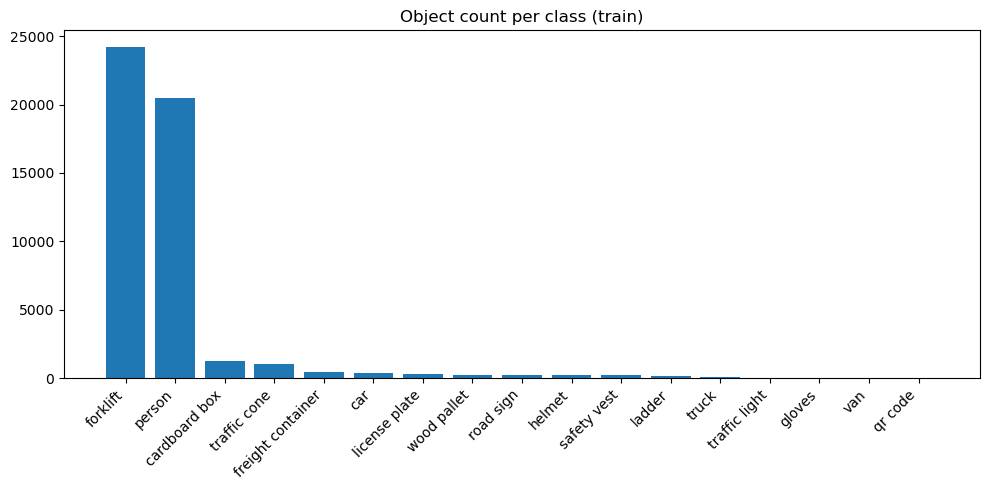

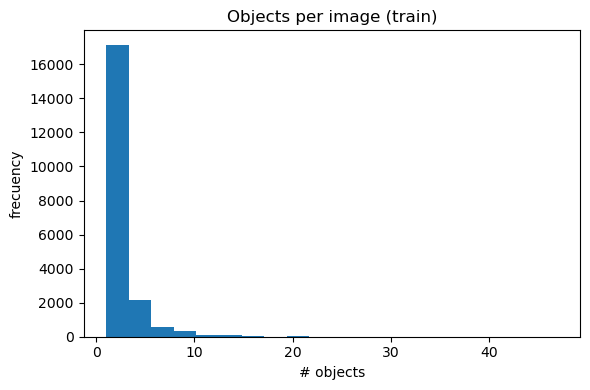

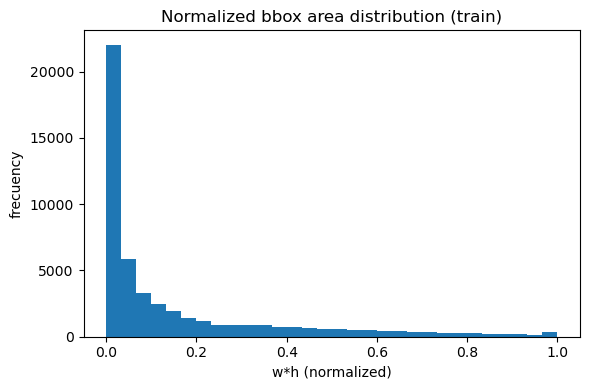

In [6]:
plt.figure(figsize=(10,5))
plt.bar(df_classes_train["class_name"], df_classes_train["count"])
plt.xticks(rotation=45, ha='right')
plt.title("Object count per class (train)")
plt.tight_layout()
plt.show()

plt.figure(figsize=(6,4))
plt.hist(df_objs_train["objects_per_image"], bins=20)
plt.title("Objects per image (train)")
plt.xlabel("# objects")
plt.ylabel("frecuency")
plt.tight_layout()
plt.show()

plt.figure(figsize=(6,4))
plt.hist(df_areas_train["bbox_area_norm"], bins=30)
plt.title("Normalized bbox area distribution (train)")
plt.xlabel("w*h (normalized)")
plt.ylabel("frecuency")
plt.tight_layout()
plt.show()

('../data/train/images/KN5F7C3Q15A9_jpg.rf.1b71d6d8bd982128cd163c625e9f7f9e.jpg', '../data/train/labels/KN5F7C3Q15A9_jpg.rf.1b71d6d8bd982128cd163c625e9f7f9e.txt')
('../data/train/images/dataq_8_jpg.rf.8ec8f4fe7bb469b18d849163efd8a1bd.jpg', '../data/train/labels/dataq_8_jpg.rf.8ec8f4fe7bb469b18d849163efd8a1bd.txt')
('../data/train/images/US5NKW65SDAG_jpg.rf.613f4e426ede9e74399b1b37bac5413f.jpg', '../data/train/labels/US5NKW65SDAG_jpg.rf.613f4e426ede9e74399b1b37bac5413f.txt')
('../data/train/images/G67JOACJXYE5_jpg.rf.6e8ccc1221cd6767ae987a660b3af495.jpg', '../data/train/labels/G67JOACJXYE5_jpg.rf.6e8ccc1221cd6767ae987a660b3af495.txt')


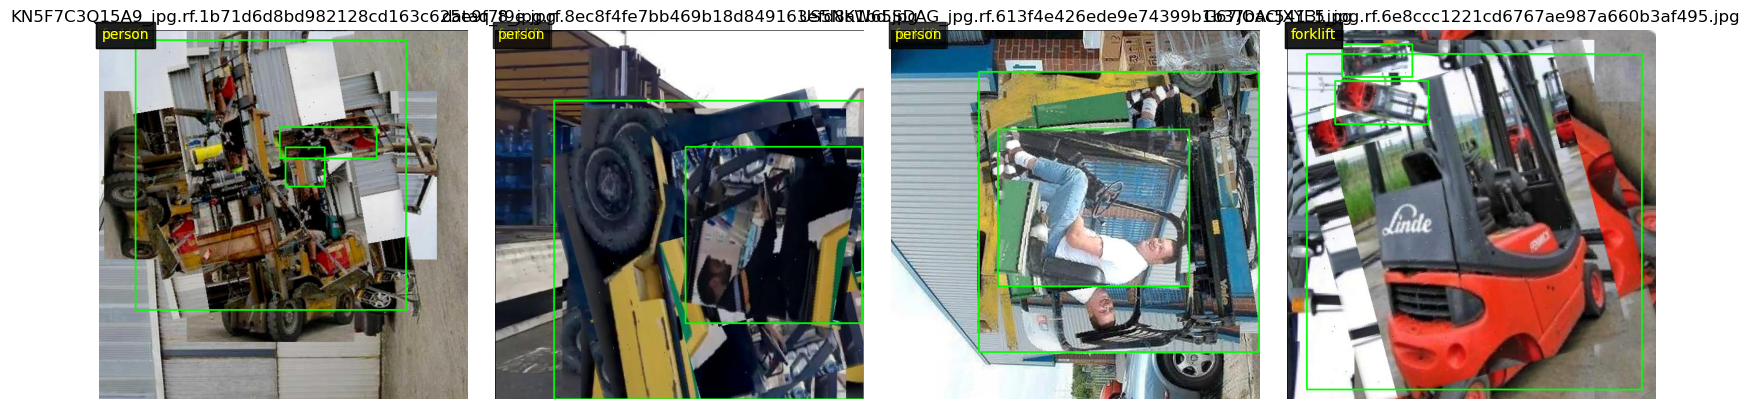

In [7]:
def draw_yolo_bbox(img, bbox, color=(0,255,0), thickness=2):
    H, W = img.shape[:2]
    cx, cy, bw, bh = bbox
    x1 = int((cx - bw/2) * W)
    y1 = int((cy - bh/2) * H)
    x2 = int((cx + bw/2) * W)
    y2 = int((cy + bh/2) * H)
    cv2.rectangle(img, (x1, y1), (x2, y2), color, thickness)
    return img

def visualize_samples(img_dir: str, class_names: list, n=4, seed=42):
    #import pdb; pdb.set_trace()
    rng = random.Random(seed)
    pairs = yolo_label_paths(img_dir)
    sample = rng.sample(pairs, min(n, len(pairs)))
    for s in sample:
        print(s)
    fig, axes = plt.subplots(1, len(sample), figsize=(4*len(sample), 4))
    if len(sample) == 1:
        axes = [axes]
    for ax, (img_path, lbl_path) in zip(axes, sample):
        img = cv2.cvtColor(cv2.imread(img_path), cv2.COLOR_BGR2RGB)
        labels = read_yolo_labels(lbl_path)
        for (cls_id, cx, cy, w, h) in labels:
            img = draw_yolo_bbox(img, (cx, cy, w, h))
            name = class_names[cls_id] if cls_id < len(class_names) else str(cls_id)
            ax.text(5, 15, name, color='yellow', bbox=dict(facecolor='black', alpha=0.5))
        ax.imshow(img)
        ax.set_title(Path(img_path).name)
        ax.axis('off')
    plt.tight_layout()
    plt.show()

visualize_samples(train_dir, class_names, n=4, seed=7)

### What methods would you use to verify the reliability of the labels?

#### 1. Check if an object was labeled with more than one class
We can verify all the boxes inside a figure and check if there is a case where two boxes are similar

In [8]:
def similar(box1, box2, threshold=0.01):
    coparession = [ abs(box1[i]-box2[i])<=threshold for i in range(4) ]
    return coparession[0] & coparession[1] & coparession[3]

def any_similar_label(labels:list):
    for i in range(len(labels)-1):
        for j in range(i+1, len(labels)):
            if similar(labels[i], labels[j]):
                return True

def verify_label_reliability(img_dir:str):
    pairs = yolo_label_paths(img_dir)
    incidences = []
    for img_path,lbl_path in pairs:
        labels = read_yolo_labels(lbl_path)
        if any_similar_label(labels):
            incidences.append(img_path)

    return incidences
        

incidences = verify_label_reliability(train_dir)
print(f"Probably {len(incidences)} files with problems")

Probably 411 files with problems


In [9]:
# CLEANINING MEMORY BEFORE TRAINING
#import torch
#torch.cuda.empty_cache()
#torch.cuda.reset_peak_memory_stats()
import torch
print("CUDA avaliable:",torch.cuda.is_available())
print("CUDA devices:", torch.cuda.device_count())

CUDA avaliable: True
CUDA devices: 1


# 2. Training

In [12]:
# ==============================
# 🔧 HYPERPARAMETERS — EXPERIMENTAL SETUP
# ==============================

# TODO: Fill in the hyperparameters based on your dataset analysis.
# Justify your choices in the Markdown cell above.
import datetime
start_train = datetime.datetime.now()
EPOCHS = 4
IMGSZ  = 320
BATCH  = 4
DEVICE = "gpu"   # cpu"        # or "cuda" if available

# Try YOLO11; if not available use YOLOv8
weights_try = ["yolo11n.pt", "yolov8n.pt"]
model = None
for w in weights_try:
    try:
        model = YOLO(w)
        print("Using:", w)
        break
    except Exception as e:
        print(f"Failed to load {w}: {e}")

assert model is not None, "Could not load a base model (yolo11n.pt / yolov8n.pt). Install ultralytics and make sure you have an active internet connection to download the weights."
end_time = datetime.datetime.now()

print("THE TRAIN TOOK: ", end_time-start_train)

# ==============================
# 🚀 TRAINING — BASELINE EXPERIMENT
# ==============================
# The results object contains metrics, charts, and run directory info.
# Feel free to adjust and rerun with different hyperparameters.

results = model.train(data=DATA_YAML_PATH, epochs=EPOCHS, imgsz=IMGSZ, batch=BATCH, device=DEVICE)
results

Using: yolo11n.pt
THE TRAIN TOOK:  0:00:00.056743
Ultralytics 8.3.233 🚀 Python-3.12.12 torch-2.5.1+cu121 


ValueError: Invalid CUDA 'device=gpu' requested. Use 'device=cpu' or pass valid CUDA device(s) if available, i.e. 'device=0' or 'device=0,1,2,3' for Multi-GPU.

torch.cuda.is_available(): True
torch.cuda.device_count(): 0
os.environ['CUDA_VISIBLE_DEVICES']: 
See https://pytorch.org/get-started/locally/ for up-to-date torch install instructions if no CUDA devices are seen by torch.


### ✏️ Discussion

Explain:
1. Why did you choose these hyperparameters?  
2. How do they affect training time, GPU/CPU usage, and accuracy?  
3. What would you try differently if you had more time or resources?

In [40]:
pairs = yolo_label_paths(train_dir)
def get_area():
    sz = {}
    for img_path, label_path in pairs:
        # Load the image
        image = cv2.imread(img_path)
        
        # Get the height and width of the image
        height, width, _ = image.shape # The third value is for channels (e.g., RGB)
        
        # Calculate the area in pixels
        area_pixels = height * width
        if area_pixels in sz:
            sz[area_pixels]+=1
        else:
            sz[area_pixels]=1
    return list(sz.keys())

areanormal = 409600 #get_area()
print("AREA:", areanormal)
normalized_areas = df_areas_train["bbox_area_norm"]

# normalized_areas: 1D array of bbox_area / image_area
def recommend_imgsz(normalized_areas, quantiles=[0.05,0.1,0.25,0.5],
                    desired_pixel_sides=[16,32,48]):
    qs = np.quantile(normalized_areas, quantiles)
    results = []
    for q, f in zip(quantiles, qs):
        side_frac = np.sqrt(f) if f>0 else 0.0
        for P in desired_pixel_sides:
            if side_frac > 0:
                imgsz = P / side_frac
            else:
                imgsz = float('inf')
            results.append({'quantile': q, 'f': float(f),
                            'side_frac': float(side_frac),
                            'desired_px': P,
                            'imgsz': imgsz})
    return results

analyss_imgsz = recommend_imgsz(normalized_areas)
pprint.pprint(analyss_imgsz)

AREA: 409600
[{'desired_px': 16,
  'f': 0.001875,
  'imgsz': np.float64(369.50417228136047),
  'quantile': 0.05,
  'side_frac': 0.04330127018922193},
 {'desired_px': 32,
  'f': 0.001875,
  'imgsz': np.float64(739.0083445627209),
  'quantile': 0.05,
  'side_frac': 0.04330127018922193},
 {'desired_px': 48,
  'f': 0.001875,
  'imgsz': np.float64(1108.5125168440816),
  'quantile': 0.05,
  'side_frac': 0.04330127018922193},
 {'desired_px': 16,
  'f': 0.0034343261718750018,
  'imgsz': np.float64(273.0229864829645),
  'quantile': 0.1,
  'side_frac': 0.058603124250119994},
 {'desired_px': 32,
  'f': 0.0034343261718750018,
  'imgsz': np.float64(546.045972965929),
  'quantile': 0.1,
  'side_frac': 0.058603124250119994},
 {'desired_px': 48,
  'f': 0.0034343261718750018,
  'imgsz': np.float64(819.0689594488935),
  'quantile': 0.1,
  'side_frac': 0.058603124250119994},
 {'desired_px': 16,
  'f': 0.010546875,
  'imgsz': np.float64(155.79663857924723),
  'quantile': 0.25,
  'side_frac': 0.10269797953

In [30]:
len(analyss_imgsz)

12

# 3. Evaluation


> 👉 **Task:** Evaluate your trained model using the validation set defined in `data.yaml`.

Run the following cell to compute key performance metrics
Then, summarize your results and provide your interpretation.

**Guidelines for your analysis:**
- **Quantitative metrics** 
- **Error analysis**
- **Next steps**

In [ ]:
# Put Here your model metrics
# TODO:
# - Run model validation on the dataset below.
# - Capture metrics and save a summary to artifacts/metrics_summary.json.
# - Optionally, add visual analysis (PR curves, confusion matrix).

# Put your model evaluation code here 👇

metrics = model.val(data=DATA_YAML_PATH, imgsz=IMGSZ, device=DEVICE)
try:
    summary = {
        "metrics/mAP50-95(B)": float(metrics.box.map if hasattr(metrics, "box") else getattr(metrics, "map", float("nan"))),
        "metrics/mAP50(B)"   : float(getattr(metrics, "map50", float("nan"))),
        "nc": int(nc),
        "classes": class_names,
        "epochs": EPOCHS,
        "imgsz": IMGSZ,
    }
except Exception as e:
    summary = {"error": str(e)}
    
os.makedirs("artifacts", exist_ok=True)
with open("artifacts/metrics_summary.json", "w") as f:
    json.dump(summary, f, indent=2)

summary


### ✏️ Metrics Interpretation and Analysis

Provide a short written analysis here:

1. **Quantitative Summary:**
   - What are your `mAP50` and `mAP50-95` values?
   - Which classes achieved the highest and lowest detection performance?

2. **Qualitative Analysis:**
   - Describe common failure cases (e.g., small objects missed, overlapping detections, background confusion).
   - Were there any label quality issues or inconsistencies you observed?

3. **Improvement Proposals:**
   - Suggest at least two improvements (data augmentation, loss tuning, class balancing, etc.).
   - How would you validate whether these changes actually help?


# 4. Inference

In [ ]:
VAL_SHOW_N = 4
val_imgs = []
for ext in ("*.jpg", "*.jpeg", "*.png"):
    val_imgs.extend(glob.glob(os.path.join(val_dir, ext)))
val_imgs = val_imgs[:VAL_SHOW_N]

pred = model.predict(source=val_imgs, imgsz=IMGSZ, conf=0.25)
# Mostrar con matplotlib (usamos 'plot' de ultralytics para guardar)
out_dir = "runs/predict_display"
os.makedirs(out_dir, exist_ok=True)

fig, axes = plt.subplots(1, len(val_imgs), figsize=(4*len(val_imgs), 4))
if len(val_imgs) == 1:
    axes = [axes]
for ax, r in zip(axes, pred):
    im = r.plot()  # numpy array con anotaciones
    ax.imshow(cv2.cvtColor(im, cv2.COLOR_BGR2RGB))
    ax.axis('off')
plt.tight_layout()
plt.show()

# 5. Export and deploy

In [ ]:

export_dir = Path("artifacts")
export_dir.mkdir(parents=True, exist_ok=True)

best_ckpt = None
for p in Path("runs/detect").rglob("weights/best.pt"):
    best_ckpt = p
    break

if best_ckpt and best_ckpt.exists():
    target = export_dir / "model_best.pt"
    target.write_bytes(best_ckpt.read_bytes())
    print("Wheight export to:", target)
else:
    print("'best.pt' not found")

with open(export_dir / "classes.json", "w") as f:
    json.dump({"nc": int(nc), "names": class_names}, f, indent=2)

try:
    _ = model.export(format="onnx", imgsz=IMGSZ)
    onnx_file = None
    for p in Path(".").rglob("*.onnx"):
        onnx_file = p
        break
    if onnx_file:
        (export_dir / "model.onnx").write_bytes(onnx_file.read_bytes())
        print("ONNX export to:", export_dir / "model.onnx")
except Exception as e:
    print("Export ONNX not available:", e)


# 6. TODOs (for the candidate)
- [ ] Analyze the class imbalance and propose strategies (weighting, augmented sampling, focal loss).
- [ ] Tune hyperparameters (epochs, image size, augmentations) to improve mAP.
- [ ] Record key metrics and justify the final baseline.
- [ ] Prepare all necessary artifacts in artifacts/ for the inference service (API).

# 7. Appendix — Notes on relative paths
- This notebook reads data.yaml and infers the paths to images/ and labels/ for train/, val/, and test/.
- If you move data.yaml to another folder, adjust DATA_YAML_PATH.
- If the dataset was downloaded from Roboflow, keep the standard YOLO folder structure.